In [115]:
from itertools import chain

from scipy.stats import norm
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [140]:
def frac(taille_échantillon, nombre_fragments):
	# On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
	if nombre_fragments > taille_échantillon:
		raise ValueError(
			'\n\n\n'
			'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
			'Vous pouvez: \n'
			'\t- Réduire le nombre de fragments demandé, en jouant sur N et sigma\n'
			'\t- Augmenter la taille des échantillons à fracturer\n'
		)
	# Il y aura n - 1 fractures pour obtenir n elements
	nombre_fractures = nombre_fragments - 1
	# Une fracture sera placée avant l'index désigné, donc une fracture
	#   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
	fractures = set()
	while len(fractures) < nombre_fractures:
		fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
	print(list(sorted(fractures))[:10])
	if len(fractures) != nombre_fractures:
		if len(fractures) < nombre_fractures:
			raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
		fractures = set(list(fractures)[:nombre_fractures])
	fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
	print(list(sorted(fractures))[-10:])
	échantillon_fracturé = [
		fractures[i + 1] - fractures[i] for i in range(nombre_fragments)
	]
	if sum(échantillon_fracturé) != taille_échantillon:
		raise RuntimeError(
			"ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
			f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
			f" fragments de différence entre ce qu'on attendais et ce qu'on a"
		)
	print(list(i for i in sorted(échantillon_fracturé))[:10])
	return échantillon_fracturé

In [193]:
def fracture(echantillons, n=65952, sigma=100):
	"""
	Fracture une liste d'échantillons en utilisant un nombre de fractures variables de loi n = Norm(N, sigma)
	:param sigma:
	:param n: Ecart-type
	:param echantillons:
	:return:
	"""
	#
	échantillons_fracturés = []

	# randn nous donne la loi normale centrée, on la convertis donc avec cette ligne
	#n = n + np.random.randn(len(echantillons)) * sigma
	n = np.random.uniform(0, 131206, len(echantillons))
	n /= len(echantillons)
	print(n)
	# On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
	for nombre_fragments, taille_échantillon in zip(map(int, n), echantillons):

		if nombre_fragments > taille_échantillon:
			raise ValueError(
				'\n\n\n'
				'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
				'Vous pouvez: \n'
				'\t- Réduire le nombre de fragments demandé, en jouant sur N et sigma\n'
				'\t- Augmenter la taille des échantillons à fracturer\n'
			)
		# Il y aura n - 1 fractures pour obtenir n elements
		nombre_fractures = nombre_fragments - 1

		# Une fracture sera placée avant l'index désigné, donc une fracture
		#   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
		fractures = set()
		while len(fractures) < nombre_fractures:
			fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
		if len(fractures) != nombre_fractures:
			if len(fractures) < nombre_fractures:
				raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
			fractures = set(list(fractures)[:nombre_fractures])
		fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
		échantillon_fracturé = [
			fractures[i + 1] - fractures[i] for i in range(nombre_fragments)
		]
		if sum(échantillon_fracturé) != taille_échantillon:
			print(taille_échantillon)
			print(sum(échantillon_fracturé))
			raise RuntimeError(
				"ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
				f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
				f" fragments de différence entre ce qu'on attendais et ce qu'on a"
			)
		échantillon_fracturé = list(i for i in sorted(échantillon_fracturé))
		échantillons_fracturés.append(échantillon_fracturé)

	return échantillons_fracturés

In [194]:
taille_genome = 1000000
nombre_morceaux = 65603

fragments = list(chain.from_iterable(fracture([taille_genome] * 1000, nombre_morceaux)))

norm = []


[108.14331687  34.06067896 127.84260127  11.34979259  60.52540989
  59.04057608  68.8669246   71.5296855   72.91318534  40.83121412
  43.27109087  16.19855394 125.22707066  98.09659037  91.67151319
   8.64886037   0.7149462   45.64179062  83.00385018  99.66832379
  24.52953471  53.60035151  43.94632074  35.23010204 125.80156307
 114.15668096 108.54728464  33.98683131  68.43552091  44.15771746
  35.62744969  40.35793797  17.48565382  66.63392595  77.73641168
   3.07885238  65.64347132 103.19324215  91.64731818  99.61741237
  32.6061264   25.23197791 130.09072175  49.45813535 105.95789101
 104.1274728  120.2302667   24.00016057  86.26288889  68.17168614
  42.69108849 117.54832712   9.06730782 122.74400396 124.84575097
  72.66243579  72.6212591   87.2800589   11.43942149  81.98811578
  46.46158973   6.38286979  32.70449643  51.86263641 109.25557212
  36.00874324  59.78258861   5.12529842  31.51458442  27.85536401
   7.47274382 118.70204827  90.02094292  70.53872548 108.38692239
 106.13468

RuntimeError: ERREUR: Une erreur s'est produite lors de la fragmentation, 
Nous avons 1000000 fragments de différence entre ce qu'on attendais et ce qu'on a

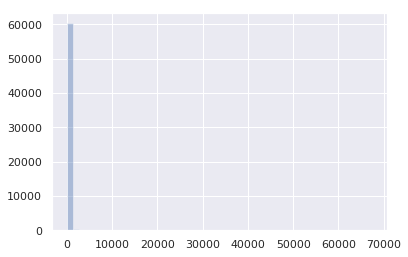

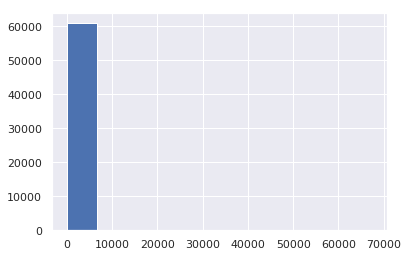

In [186]:
sns.set(color_codes=True)
sns.distplot(fragments, kde=False, rug=False)
plt.show()
if __name__ == '__main__':
	plt.hist(fragments)
	plt.show()


In [183]:
taille_genome = 1000000
nombre_morceaux = 65719

fragments = list(chain.from_iterable(fracture([taille_genome] * 1000, nombre_morceaux)))

norm = []
sns.set(color_codes=True)
sns.distplot(fragments, kde=False, rug=False)
plt.show()
if __name__ == '__main__':
	plt.hist(fragments)
	plt.show()


RuntimeError: ERREUR: Une erreur s'est produite lors de la fragmentation, 
Nous avons 1000000 fragments de différence entre ce qu'on attendais et ce qu'on a